In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_4068/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
df1 = pd.read_csv("SRER21_dataset_v1.csv", na_values = '?').dropna()
df1['year'] = 2017
df2 = pd.read_csv("SRER21_dataset_v1.csv", na_values = '?').dropna()
df2['year'] = 2021
frames = [df1, df2]
df = pd.concat(frames)
df = df.reindex(columns=['OID_', 'Id', 'gridcode', 'Shape_Length', 'Shape_Area', 'CH_mean', 'ARVI_mean', 'ARVI_med', 'ARVI_max', 'EVI_mean', 'EVI_med', 'EVI_max', 'NDVI_mean', 'NDVI_med', 'NDVI_max', 'SAVI_mean', 'SAVI_med', 'SAVI_max', 'year', 'Veg_class'])
df


,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,year,Veg_class
0,2,2,2,20.4,2.38,1.000000,0.273945,0.273945,0.273945,0.323257,0.323257,0.323257,0.428208,0.428208,0.428208,0.311936,0.311936,0.311936,2017,woody
1,3,3,3,8.2,1.32,1.000000,0.530157,0.530157,0.530157,0.460513,0.460513,0.460513,0.611745,0.611745,0.611745,0.416492,0.416492,0.416492,2017,woody
2,4,4,4,55.8,24.43,0.920000,0.477979,0.501013,0.616707,0.381095,0.384718,0.447304,0.576437,0.596638,0.673767,0.359786,0.364317,0.414173,2017,woody
3,5,5,5,15.2,1.88,1.000000,0.342944,0.342944,0.342944,0.346714,0.346714,0.346714,0.468738,0.468738,0.468738,0.323907,0.323907,0.323907,2017,woody
4,6,6,6,27.2,9.29,0.142857,0.044382,-0.008903,0.265536,0.181714,0.147391,0.315684,0.223522,0.178629,0.412030,0.177739,0.147325,0.299311,2017,non-woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,7761,7761,7761,12.0,1.59,0.666667,0.536690,0.552596,0.568966,0.378935,0.397165,0.403695,0.615736,0.627957,0.640278,0.358073,0.373771,0.377543,2021,woody
7760,7762,7762,7762,14.6,3.20,1.000000,0.482610,0.482610,0.483734,0.322043,0.322043,0.324235,0.576554,0.576554,0.577511,0.312786,0.312786,0.314608,2021,woody
7761,7763,7763,7763,10.6,2.24,0.500000,0.446487,0.446487,0.517261,0.364414,0.364414,0.412901,0.559486,0.559486,0.608110,0.348984,0.348984,0.386288,2021,woody
7764,7766,7766,7766,16.2,3.62,0.666667,0.578637,0.594556,0.623445,0.268822,0.271254,0.306740,0.614486,0.620037,0.654546,0.262576,0.265154,0.296495,2021,woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(df): 
    
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.33791422499999957 seconds ---

Accuracy of each fold: 
 [0.8445995591476855, 0.8361498897869214, 0.8486407053637032, 0.8445995591476855, 0.834313005143277]
Avg accuracy: 0.8416605437178545
Std of accuracy : 
0.0054836467765011785

[[3468  992]
 [1163 7987]]

              precision    recall  f1-score   support

   non-woody       0.75      0.78      0.76      4460
       woody       0.89      0.87      0.88      9150

    accuracy                           0.84     13610
   macro avg       0.82      0.83      0.82     13610
weighted avg       0.84      0.84      0.84     13610

0.7775784753363228
0.872896174863388
0.7488663355646729
0.7629523704762953


In [7]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []
  
for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 1.0086149090000003 seconds ---

Accuracy of each fold: 
 [0.8519470977222631, 0.8526818515797208, 0.8677443056576047, 0.8633357825128581, 0.8519470977222631]
Avg accuracy: 0.8575312270389419
Std of accuracy : 
0.006691506286570152

[[3586  874]
 [1065 8085]]

              precision    recall  f1-score   support

   non-woody       0.77      0.80      0.79      4460
       woody       0.90      0.88      0.89      9150

    accuracy                           0.86     13610
   macro avg       0.84      0.84      0.84     13610
weighted avg       0.86      0.86      0.86     13610

0.8040358744394619
0.8836065573770492
0.7710169855944958
0.7871803314674569


In [8]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 1.5481464479999998 seconds ---

Accuracy of each fold: 
 [0.8199853049228508, 0.8258633357825128, 0.8291697281410727, 0.8398236590742102, 0.8295371050698016]
Avg accuracy: 0.8288758265980898
Std of accuracy : 
0.006457479072070516

[[3641  819]
 [1510 7640]]

              precision    recall  f1-score   support

   non-woody       0.71      0.82      0.76      4460
       woody       0.90      0.83      0.87      9150

    accuracy                           0.83     13610
   macro avg       0.81      0.83      0.81     13610
weighted avg       0.84      0.83      0.83     13610

0.8163677130044843
0.8349726775956284
0.706853038245001
0.7576734991155968


#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [9]:
KNN_result = []
X=df.iloc[:, 5:19]
Y=df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.80822924 0.79647318 0.82916973 0.81300514 0.81447465]

Avg accuracy: 0.8122703894195444

K=2

Accuracy of each fold: 
 [0.80859662 0.79831007 0.81337252 0.81300514 0.80933137]

Avg accuracy: 0.80852314474651

K=3

Accuracy of each fold: 
 [0.83394563 0.82145481 0.84496694 0.83835415 0.82696547]

Avg accuracy: 0.8331373989713446

K=4

Accuracy of each fold: 
 [0.83247612 0.82402645 0.85047759 0.8328435  0.82623071]

Avg accuracy: 0.8332108743570904

K=5

Accuracy of each fold: 
 [0.84386481 0.82696547 0.85892726 0.84386481 0.83982366]

Avg accuracy: 0.8426891991182954

K=6

Accuracy of each fold: 
 [0.83982366 0.83137399 0.85892726 0.83945628 0.83210874]

Avg accuracy: 0.8403379867744306

K=7

Accuracy of each fold: 
 [0.85231447 0.83872153 0.86223365 0.85231447 0.83945628]

Avg accuracy: 0.8490080822924322

K=8

Accuracy of each fold: 
 [0.84937546 0.83504776 0.85855988 0.85157972 0.83908891]

Avg accuracy: 0.8467303453343129

K=9

Accuracy of each fold

In [10]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=8)

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 10.016861069999997 seconds ---

Accuracy of each fold: 
 [0.8493754592211609, 0.8350477590007348, 0.8585598824393829, 0.8515797207935342, 0.8390889052167524]
Avg accuracy: 0.8467303453343129
Std of accuracy : 
0.008547811982617415

[[3595  865]
 [1221 7929]]

              precision    recall  f1-score   support

   non-woody       0.75      0.81      0.78      4460
       woody       0.90      0.87      0.88      9150

    accuracy                           0.85     13610
   macro avg       0.82      0.84      0.83     13610
weighted avg       0.85      0.85      0.85     13610

0.8060538116591929
0.8665573770491803
0.7464700996677741
0.7751185855972401


In [11]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.841661,0.005484,0.777578,0.872896,0.748866,0.762952,0.337914
LDA,0.857531,0.006692,0.804036,0.883607,0.771017,0.787180,1.008615
QDA,0.828876,0.006457,0.816368,0.834973,0.706853,0.757673,1.548146
KNN-CV,0.846730,0.008548,0.806054,0.866557,0.746470,0.775119,10.016861


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.8416605437178545, 0.8575312270389419, 0.8288758265980898, 0.8467303453343129]
Sen[0.7775784753363228, 0.8040358744394619, 0.8163677130044843, 0.8060538116591929]
Spec[0.872896174863388, 0.8836065573770492, 0.8349726775956284, 0.8665573770491803]
P[0.7488663355646729, 0.7710169855944958, 0.706853038245001, 0.7464700996677741]
F1[0.7629523704762953, 0.7871803314674569, 0.7576734991155968, 0.7751185855972401]


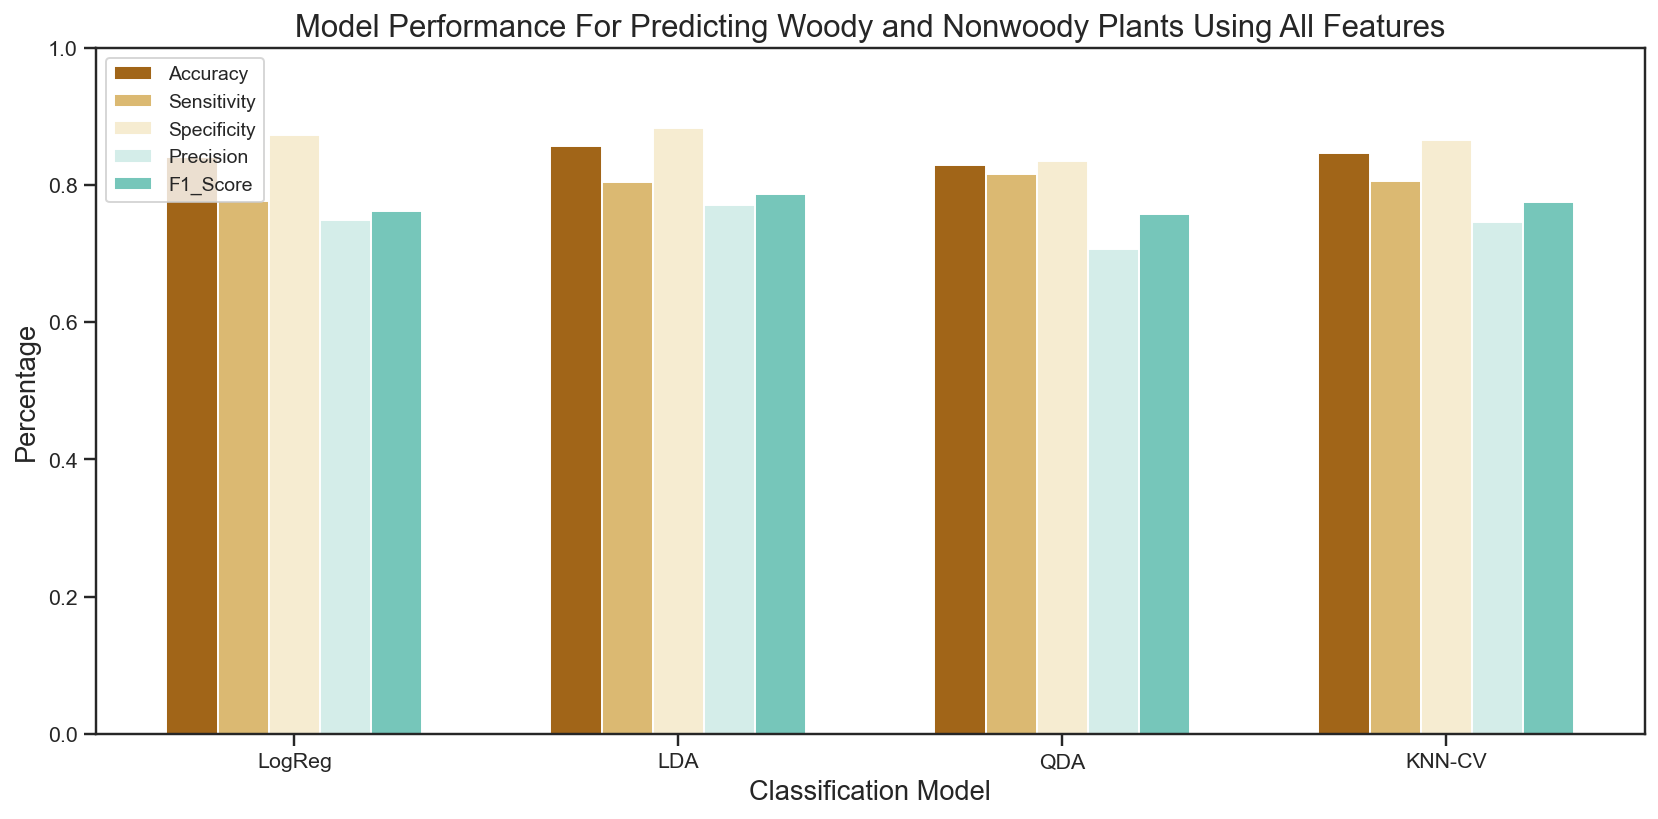

In [12]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

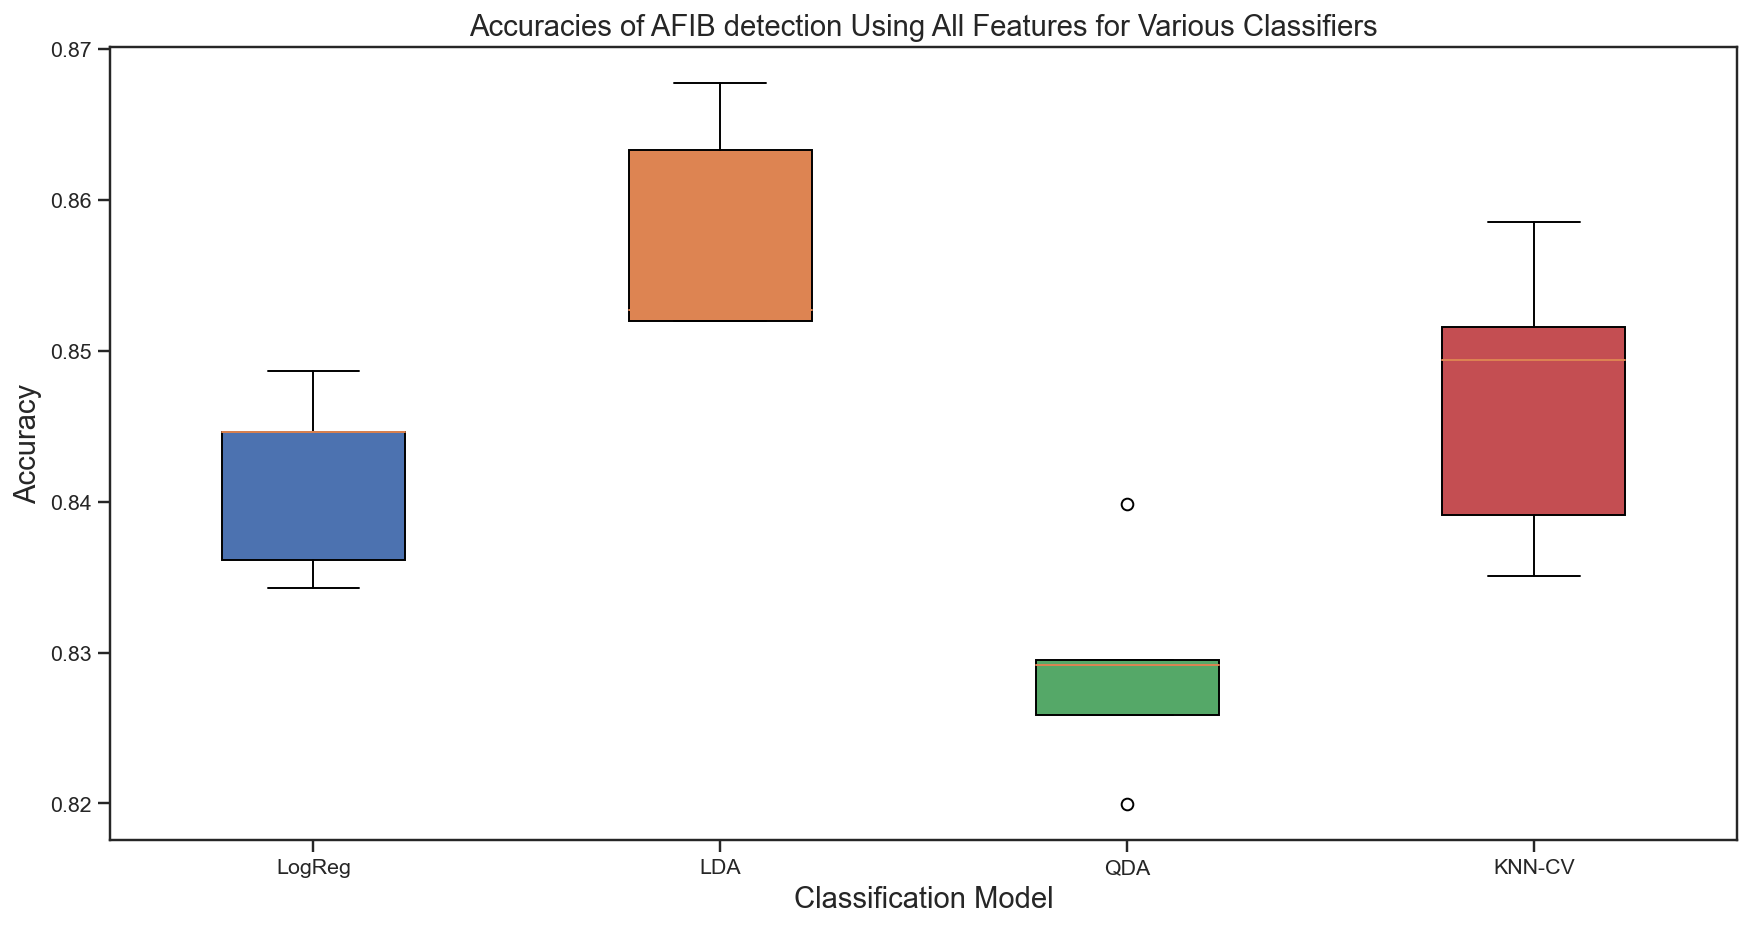

In [13]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()